<a href="https://colab.research.google.com/github/kyohei-123/autoencoder-test/blob/master/cifar_deep_R1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN with Autoencoder for cifar10

# 0. Introduction
In this notebook, CNN(supervised) and Autoencoder(unsupervised) mixing method is introduced for cifar10 classification.   
Likns below helped me a lot.

Ref1
https://www.tensorflow.org/tutorials/images/cnn  
Ref2 https://deepage.net/deep_learning/2016/10/09/deeplearning_autoencoder.html　　  
Ref3 http://ipr20.cs.ehime-u.ac.jp/column/neural/chapter6.html  
Ref4 https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763　　　<br>
Ref5 https://sefiks.com/2018/03/23/convolutional-autoencoder-clustering-images-with-neural-networks/　　  
Ref6 https://qiita.com/slowsingle/items/bb1671d4a6b19820db5c  

# 1. Data prep

In [558]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from  sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [559]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# https://analytics-note.xyz/machine-learning/keras-check-point/

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="model-{epoch:02d}-{val_loss:.2f}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

In [560]:
### Load data

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1aa
train_images, test_images = train_images / 255.0, test_images / 255.0



In [561]:
### Prep data
### In this notebook, number of data are specified as below.
### 2500 training data for bird, deer, truck
### 5000 train data for each remainig 7 class
### 1000 test data for each 10 class

bird_indexes = [i for i, label in enumerate(train_labels) if label==2]
deer_indexes = [i for i, label in enumerate(train_labels) if label==4]
truck_indexes = [i for i, label in enumerate(train_labels) if label==9]
other_indexes = [i for i, label in enumerate(train_labels) if label in (0,1,3,5,6,7,8)] 

train_images_bird, _ = train_test_split(train_images[bird_indexes],train_size=0.5,random_state=0)
train_images_deer, _ = train_test_split(train_images[deer_indexes],train_size=0.5,random_state=0)
train_images_truck, _ = train_test_split(train_images[truck_indexes],train_size=0.5,random_state=0)

train_images = np.vstack([train_images_bird, train_images_deer, train_images_truck, train_images[other_indexes]])
train_labels = np.vstack([(np.ones((2500,1))*2).astype(int), (np.ones((2500,1))*4).astype(int), 
                          (np.ones((2500,1))*9).astype(int), train_labels[other_indexes]])

train_labels_cat = train_labels.copy()
test_labels_cat = test_labels.copy()
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)


print(f"data all # : {train_images.shape}")
print(f"birds data # : {train_images_bird.shape}")
print(f"deers data # : {train_images_deer.shape}")
print(f"trucks data # : {train_images_truck.shape}")
print(f"image.shape = {train_images[0].shape}")

picture_shape = train_images[0].shape



data all # : (42500, 32, 32, 3)
birds data # : (2500, 32, 32, 3)
deers data # : (2500, 32, 32, 3)
trucks data # : (2500, 32, 32, 3)
image.shape = (32, 32, 3)


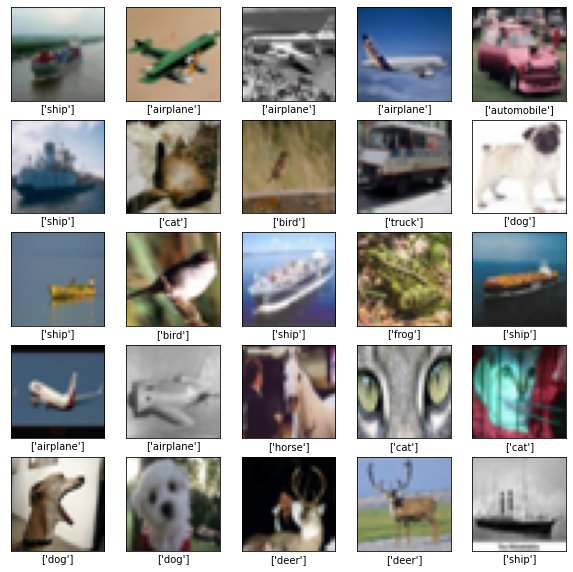

In [562]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


# 2.1 Autoencoder

In [563]:
### Make autoencoder

### Make encoder
input_img = keras.Input(shape=picture_shape)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(input_img)
x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.MaxPool2D(pool_size=(2,2))(x)

encoded = x

### Make decoder
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same', strides=1)(x)
# x = layers.UpSampling2D(size=(2,2))(x)
# x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2D(filters=3, kernel_size=(3, 3), padding='same')(x)

decoded = x

### Combine
autoencoder = keras.Model(inputs=input_img, outputs=decoded)
encoder = keras.Model(inputs=input_img, outputs=encoded)

print(autoencoder.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 32, 32, 8)         224       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 16, 16, 8)         584       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 32, 32, 3)         219       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
________________________________________________________

In [565]:
### Train autoencoder

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/ae-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

autoencoder.compile(optimizer='adam',
                    loss=keras.losses.mean_squared_error,
                    metrics=['accuracy'])

history_autoencoder = autoencoder.fit(train_images, train_images,
                epochs=50,
                shuffle=True,
                batch_size=256,
                validation_data=(test_images,test_images),
                callbacks=[checkpoint])


Epoch 1/50
167/167 [==============================] - 33s 195ms/step - loss: 0.0171 - accuracy: 0.5184 - val_loss: 0.0051 - val_accuracy: 0.7029
Epoch 2/50
 88/167 [==============>...............] - ETA: 13s - loss: 0.0048 - accuracy: 0.7121

KeyboardInterrupt: 

In [ ]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

In [ ]:
i = 12
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(train_images[i])
plt.xlabel('raw picture')
plt.subplot(1,2,2)
plt.imshow(autoencoder.predict(train_images[[i]]).reshape(32,32,3))
plt.xlabel('autoencodered')



      
      
Ok, seems my autoencoder works well!   
   

# 2.2 CNN with Encoder

In [526]:
### Build CNN with input from encoder

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dense(10))

cnn.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_9 (Functional)         (None, 16, 16, 8)         224       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 14, 14, 64)        4672      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)              

My cnn has 110K trainable parameters. In the following section, my baseline model shoud have same number of parameters so that they are comparable.

In [527]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae0-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=50,batch_size=256, shuffle=True,
                     callbacks=[checkpoint])

Epoch 1/50
167/167 [==============================] - 11s 65ms/step - loss: 2.0022 - accuracy: 0.2724 - val_loss: 1.8910 - val_accuracy: 0.3464
Epoch 2/50
167/167 [==============================] - 10s 62ms/step - loss: 1.5500 - accuracy: 0.4477 - val_loss: 2.1419 - val_accuracy: 0.3043
Epoch 3/50
167/167 [==============================] - 10s 59ms/step - loss: 1.4806 - accuracy: 0.4816 - val_loss: 1.4886 - val_accuracy: 0.4511
Epoch 4/50
167/167 [==============================] - 9s 56ms/step - loss: 1.3244 - accuracy: 0.5295 - val_loss: 1.4820 - val_accuracy: 0.4533
Epoch 5/50
167/167 [==============================] - 10s 60ms/step - loss: 1.2806 - accuracy: 0.5441 - val_loss: 1.3913 - val_accuracy: 0.5019
Epoch 6/50
167/167 [==============================] - 11s 64ms/step - loss: 1.2197 - accuracy: 0.5738 - val_loss: 1.7978 - val_accuracy: 0.4239
Epoch 7/50
167/167 [==============================] - 9s 53ms/step - loss: 1.2745 - accuracy: 0.5559 - val_loss: 1.2902 - val_accuracy: 0

Best Validation Loss: 1.0559
Best Validation Accuracy: 0.6462


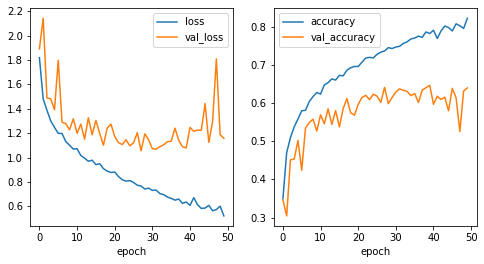

In [528]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

It seems overfitting started from epoch10. Also the validation score is affected by the choice of data. I will restart training from epoch20 and increase the batch size

In [553]:
cnn = keras.models.load_model("./saved_model/cnn_ae0-010-1.32.h5")

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae1-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024, shuffle=True,
                     callbacks=[checkpoint])

Epoch 1/10
57/57 [==============================] - 13s 214ms/step - loss: 1.1440 - accuracy: 0.5844 - val_loss: 1.1994 - val_accuracy: 0.5773
Epoch 2/10
57/57 [==============================] - 12s 207ms/step - loss: 1.0717 - accuracy: 0.6106 - val_loss: 1.1447 - val_accuracy: 0.5942
Epoch 3/10
57/57 [==============================] - 11s 200ms/step - loss: 1.0526 - accuracy: 0.6248 - val_loss: 1.1441 - val_accuracy: 0.5929
Epoch 4/10
57/57 [==============================] - 12s 211ms/step - loss: 1.0363 - accuracy: 0.6263 - val_loss: 1.1525 - val_accuracy: 0.5951
Epoch 5/10
57/57 [==============================] - 12s 218ms/step - loss: 1.0244 - accuracy: 0.6350 - val_loss: 1.1595 - val_accuracy: 0.5913
Epoch 6/10
57/57 [==============================] - 11s 196ms/step - loss: 1.0107 - accuracy: 0.6379 - val_loss: 1.1373 - val_accuracy: 0.5947
Epoch 7/10
57/57 [==============================] - 12s 209ms/step - loss: 1.0048 - accuracy: 0.6387 - val_loss: 1.2232 - val_accuracy: 0.5781

Best Validation Loss: 1.0974
Best Validation Accuracy: 0.6122


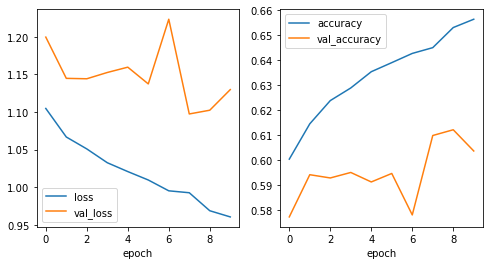

In [554]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

# 2.3 CNN Baseline

In [531]:
### Check score of baseline model
### I defined my baseline model as below
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dense(10))

basemodel.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_18 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)              

In my base cnn model above, trainable parameters are 120K, which are almost same for previous cnn with encoder input, which means those models are comparable.

In [532]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base0-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=50,batch_size=256,shuffle=True,
                  callbacks=[checkpoint]
                  )

Epoch 1/50
167/167 [==============================] - 17s 99ms/step - loss: 1.9365 - accuracy: 0.2947 - val_loss: 1.6579 - val_accuracy: 0.4052
Epoch 2/50
167/167 [==============================] - 16s 96ms/step - loss: 1.4258 - accuracy: 0.4859 - val_loss: 1.5397 - val_accuracy: 0.4417
Epoch 3/50
167/167 [==============================] - 17s 103ms/step - loss: 1.2755 - accuracy: 0.5481 - val_loss: 1.5205 - val_accuracy: 0.4700
Epoch 4/50
167/167 [==============================] - 16s 96ms/step - loss: 1.2218 - accuracy: 0.5665 - val_loss: 1.3784 - val_accuracy: 0.5042
Epoch 5/50
167/167 [==============================] - 17s 101ms/step - loss: 1.1349 - accuracy: 0.5963 - val_loss: 1.7307 - val_accuracy: 0.4203
Epoch 6/50
167/167 [==============================] - 18s 106ms/step - loss: 1.1600 - accuracy: 0.5900 - val_loss: 1.3021 - val_accuracy: 0.5386
Epoch 7/50
167/167 [==============================] - 17s 102ms/step - loss: 1.0663 - accuracy: 0.6273 - val_loss: 1.1778 - val_accur

Best Validation Loss: 0.8817
Best Validation Accuracy: 0.7100


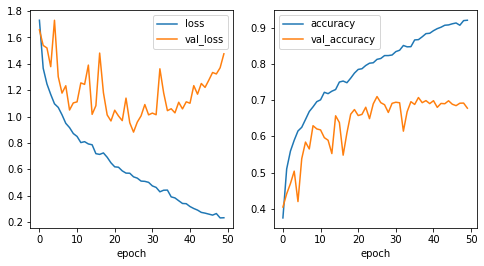

In [533]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

It is not stable. I will restart training from epoch 10 and increas batch size

In [556]:
basemodel = keras.models.load_model("./saved_model/cnn_base0-010-1.10.h5")

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base1-{epoch:03d}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=10,batch_size=1024,shuffle=True,
                  callbacks=[checkpoint]
                  )

Epoch 1/10
57/57 [==============================] - 19s 321ms/step - loss: 1.0078 - accuracy: 0.6411 - val_loss: 0.9584 - val_accuracy: 0.6686
Epoch 2/10
57/57 [==============================] - 17s 294ms/step - loss: 0.8623 - accuracy: 0.6886 - val_loss: 0.9370 - val_accuracy: 0.6757
Epoch 3/10
57/57 [==============================] - 17s 295ms/step - loss: 0.8556 - accuracy: 0.6921 - val_loss: 0.9343 - val_accuracy: 0.6765
Epoch 4/10
57/57 [==============================] - 17s 306ms/step - loss: 0.8427 - accuracy: 0.6988 - val_loss: 0.9493 - val_accuracy: 0.6704
Epoch 5/10
57/57 [==============================] - 16s 285ms/step - loss: 0.8161 - accuracy: 0.7078 - val_loss: 0.9282 - val_accuracy: 0.6791
Epoch 6/10
57/57 [==============================] - 17s 292ms/step - loss: 0.8071 - accuracy: 0.7126 - val_loss: 0.9422 - val_accuracy: 0.6747
Epoch 7/10
57/57 [==============================] - 16s 279ms/step - loss: 0.7942 - accuracy: 0.7113 - val_loss: 0.8988 - val_accuracy: 0.6922

Best Validation Loss: 0.8988
Best Validation Accuracy: 0.6922


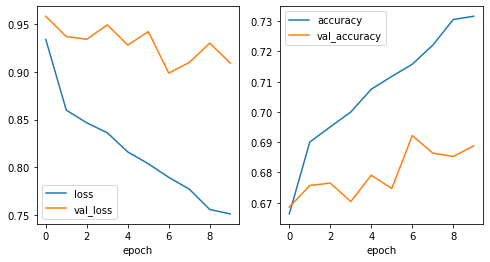

In [557]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

The gap between the training loss and test loss is getting wider, suggesting overfitting to training data.

# 2.4 Evaluate result

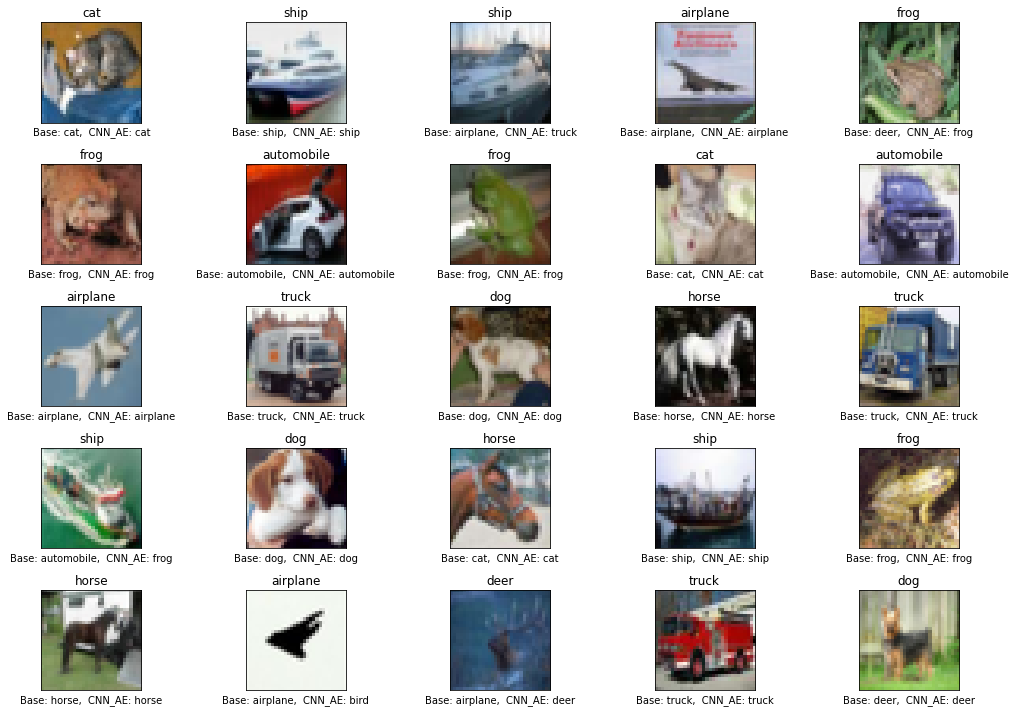

In [536]:
# i = 6
plt.figure(figsize=(15,10),tight_layout=True)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(test_images[i])
    res_base = class_names[np.argmax(basemodel.predict(test_images[[i]]))]
    res_cnn = class_names[np.argmax(cnn.predict(test_images[[i]]))]
    plt.xlabel(f"Base: {res_base},  CNN_AE: {res_cnn}")
    plt.title(class_names[np.argmax(test_labels[i])])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
plt.show()

In [537]:
test_pred_cnn = cnn.predict(test_images)
test_pred_basemodel = basemodel.predict(test_images)

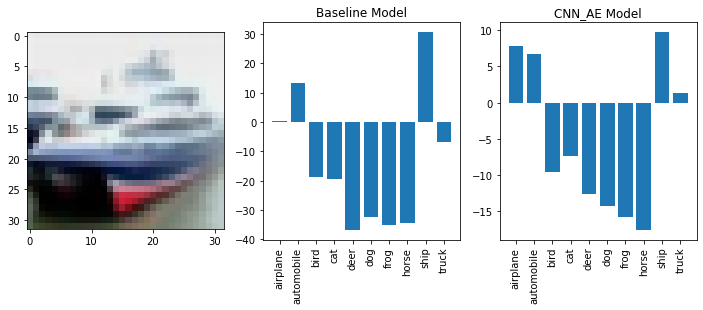

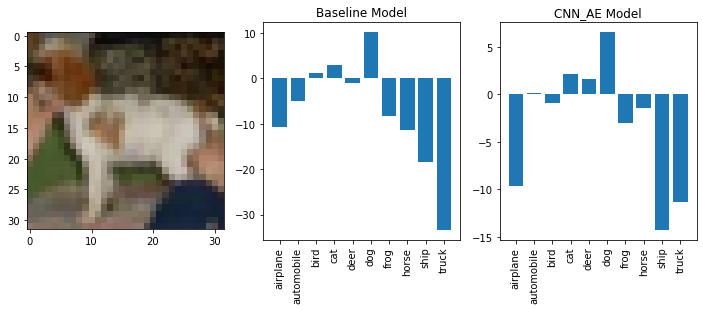

In [538]:
### Check how much confident my models predict each test data

i=1
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

i=12
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_images[i])
plt.subplot(1,3,2)
plt.bar(x = class_names, height = test_pred_basemodel[i])
plt.xticks(rotation=90)
plt.title('Baseline Model')
plt.subplot(1,3,3)
plt.bar(x = class_names, height = test_pred_cnn[i])
plt.xticks(rotation=90)
plt.title('CNN_AE Model')
plt.show()

Ah, ok my models can distinguish between "animal" and "machine", but diffcult to tell which "machine" or which "animal" it is. 

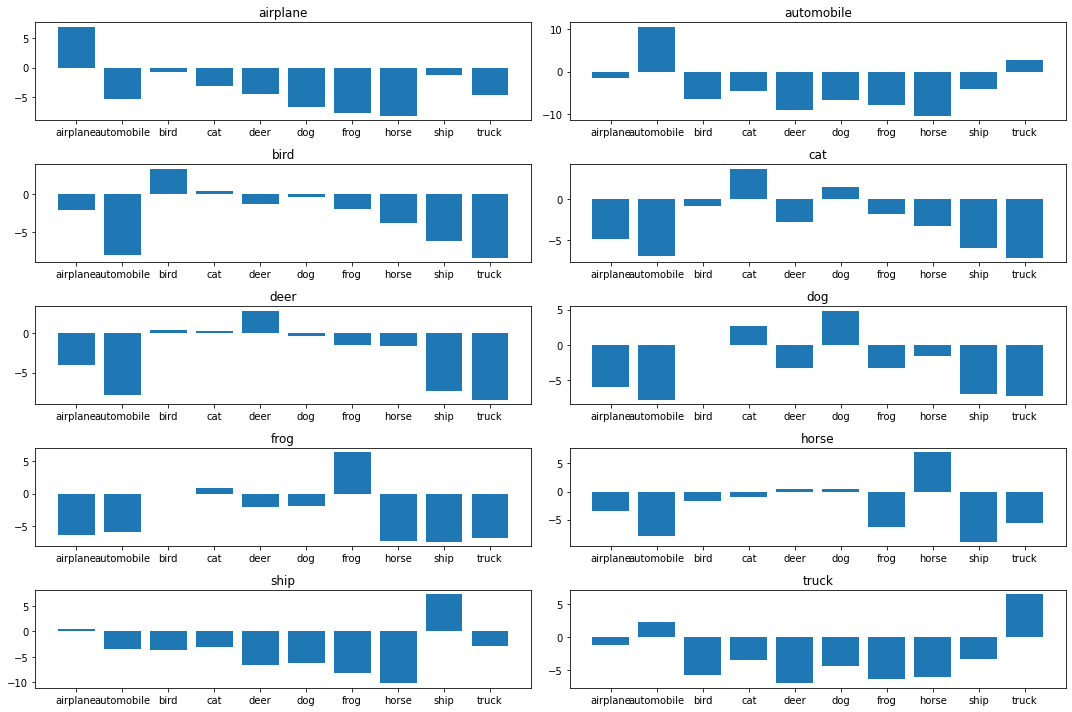

In [539]:
### Check how much confident my models predict each test data

result_df = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df = pd.concat([result_df, pd.DataFrame(test_pred_cnn,columns = class_names)],axis=1)

# label = "airplane"
plt.figure(figsize=(15,10),tight_layout=True)
for i,label in enumerate(class_names):
    filter = result_df[label+"_label"]==1
    plt.subplot(5,2,i+1)
    plt.bar(x=class_names, height = result_df[filter][class_names].mean())
    plt.title(label)

Ok, my model has difficulty to distinguish bird, cat, dog and deer. Maybe I can improve my model by augmenting data. I hope I can improve my model for deer since they have distinct feature.

# 3. Data augmentation

Since the animals are hard to tell which is which, I introduce data augmentation to train my model more.

# 3.1 Data augmentation

In [540]:
### Data augmentation (2times of bird, dog, cat and deer)
### In animal pictures, many pausings can be found. Therefore, animal's rotation will not be important feature, so I will augment animal pictures by rotation.


def func_augment(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # ImageDataGeneratorの生成
    datagen = ImageDataGenerator(
        rotation_range=30
    )

    g = datagen.flow(x, batch_size=1)
    batch=[]
    for i in range(1):
        batch.append(g.next())
    return batch
# i = 0
# x = train_images[i]
# y = func_augment(x)[0]

In [541]:
### bird
filter = np.where(train_labels_cat==2)[0]
bird_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    bird_adds = np.vstack((bird_adds,func_augment(img)[0]))

### cat
filter = np.where(train_labels_cat==3)[0]
cat_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    cat_adds = np.vstack((cat_adds,func_augment(img)[0]))

### deer
filter = np.where(train_labels_cat==4)[0]
deer_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    deer_adds = np.vstack((deer_adds,func_augment(img)[0]))

### dog
filter = np.where(train_labels_cat==5)[0]
dog_adds = func_augment(train_images[filter][0])[0]
for img in train_images[filter][1:]:
    dog_adds = np.vstack((dog_adds,func_augment(img)[0]))

In [542]:
train_images = np.vstack([train_images,bird_adds,cat_adds,deer_adds,dog_adds])
train_labels_cat = np.vstack([train_labels_cat, (np.ones((2500,1))*2).astype(int), (np.ones((5000,1))*3).astype(int), 
                          (np.ones((2500,1))*4).astype(int), (np.ones((5000,1))*5).astype(int)])

In [543]:
train_labels = keras.utils.to_categorical(train_labels_cat, 10)
train_images, train_labels, train_labels_cat = shuffle(train_images, train_labels, train_labels_cat, random_state=0)

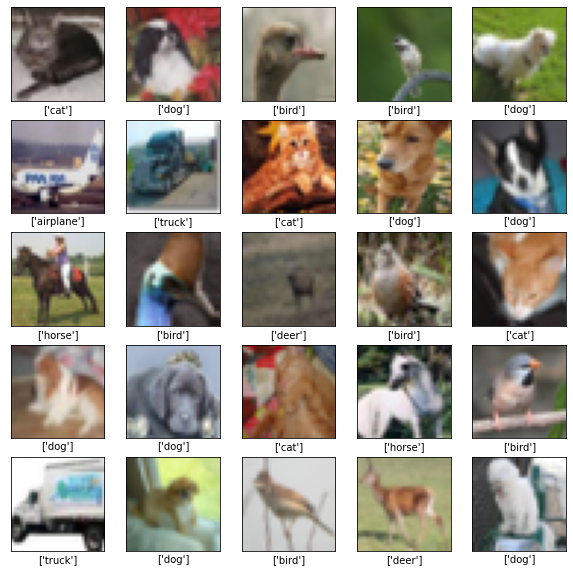

In [544]:
### check labeling

class_names = pd.Series(['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'])

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i].astype(bool)].values)
plt.show()


# 3.2 Training with augmented data
## 3.2.1 CNN with Autoencoder

In [545]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae_aug-{epoch:03d}-{val_loss:.2f}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

### CNN with Autoencoder

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=50,batch_size=1024, shuffle=True,
                    callbacks=[checkpoint])


### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_autoencoder_df = pd.DataFrame(history_autoencoder.history)

check_history(history_autoencoder_df)

Epoch 1/50
57/57 [==============================] - 14s 227ms/step - loss: 0.5909 - accuracy: 0.8035 - val_loss: 1.4401 - val_accuracy: 0.6440
Epoch 2/50
57/57 [==============================] - 11s 201ms/step - loss: 0.4786 - accuracy: 0.8425 - val_loss: 1.4149 - val_accuracy: 0.6460
Epoch 3/50
57/57 [==============================] - 12s 204ms/step - loss: 0.4597 - accuracy: 0.8470 - val_loss: 1.4156 - val_accuracy: 0.6438
Epoch 4/50
57/57 [==============================] - 11s 191ms/step - loss: 0.4496 - accuracy: 0.8524 - val_loss: 1.4109 - val_accuracy: 0.6446
Epoch 5/50
57/57 [==============================] - 12s 217ms/step - loss: 0.4404 - accuracy: 0.8537 - val_loss: 1.4359 - val_accuracy: 0.6421
Epoch 6/50
57/57 [==============================] - 12s 212ms/step - loss: 0.4483 - accuracy: 0.8484 - val_loss: 1.4363 - val_accuracy: 0.6455
Epoch 7/50
57/57 [==============================] - 11s 200ms/step - loss: 0.4409 - accuracy: 0.8503 - val_loss: 1.4081 - val_accuracy: 0.6452

KeyboardInterrupt: 

## 3.2.2 Baseline CNN model

In [ ]:
### Baseline

# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base_aug-{epoch:03d}-{val_loss:.2f}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )


basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=50,batch_size=1024,shuffle=True,
                  callbacks=[checkpoint]
                  )



### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))

history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

Oh, now baseline model didn't imporove. Larger gap suggests me over fitting.
On the other hand, cnn_ae improved a lot, the learning curves between training and test stay consistent, which could be the benefit from encoder where only feature are extracted so my model was not affected by noise!

# 3.3 Evaluate Results

In [ ]:
### Check how much confident my models predict each test data

cnn1 = keras.models.load_model("./saved_model/cnn.h5")
cnn2 = keras.models.load_model("./saved_model/cnn_aug.h5")
cnn3 = keras.models.load_model("./saved_model/basemodel_aug.h5")

test_pred_cnn1 = cnn1.predict(test_images)
test_pred_cnn2 = cnn2.predict(test_images)
test_pred_cnn3 = cnn3.predict(test_images)

result_df1 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df2 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df3 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df1 = pd.concat([result_df1, pd.DataFrame(test_pred_cnn1,columns = class_names)],axis=1)
result_df2 = pd.concat([result_df2, pd.DataFrame(test_pred_cnn2,columns = class_names)],axis=1)
result_df3 = pd.concat([result_df3, pd.DataFrame(test_pred_cnn3,columns = class_names)],axis=1)

plt.figure(figsize=(15,10),tight_layout=True)
for i, label in enumerate(class_names):
    filter = result_df1[label+'_label']==1
    h1 = result_df1[filter][class_names].mean()
    h2 = result_df2[filter][class_names].mean()
    h3 = result_df3[filter][class_names].mean()
    plt.subplot(5,2,i+1)
    plt.bar(x=np.arange(0,10,1),height=h1.values,width=0.2,color='r',label="cnn_ae")
    plt.bar(x=np.arange(0,10,1)+0.2, height=h2.values, width=0.2,color='b',label="cnn_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.4, height=h3.values, width=0.2,color='g',label="base_ae_aug")
    plt.xticks(ticks=np.arange(0,10,1)+0.3, labels=class_names)
    plt.title(label)
    plt.legend()
plt.show()
    
# label = "airplane"
# plt.figure(figsize=(15,10),tight_layout=True)
# for i,label in enumerate(class_names):
#     filter = result_df1[label+"_label"]==1
#     plt.subplot(5,2,i+1)
#     plt.bar(x=class_names, height = result_df1[filter][class_names].mean())
#     plt.title(label)

On the whole, cnn_ae_aug (CNN with Autoencoder with augmented data) shows better classification peformance. But still cat and dog is difficult to distinguish.

In [ ]:
### I want to check how the cats and dogs look like to get modeling idea.
plt.figure(figsize=(15,8),tight_layout=True)
for i,img in enumerate(test_images[np.where(test_labels_cat==3)[0]][5:10]):
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
for i,img in enumerate(test_images[np.where(test_labels_cat==5)[0]][5:10]):
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [ ]:
### Most dog like cat
filter = result_df2["cat_label"]==1
idx = result_df2[filter]['dog'].idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

For example, this dog-like-cat is difficult to tell.

In [ ]:
### Most cat like cat
filter = result_df2["cat_label"]==1
idx = result_df2[filter]['cat'].idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

Understandable.

In [ ]:
### Cat with most gap (dog-cat)
filter = result_df2["cat_label"]==1
idx = (result_df2[filter]['dog']-result_df2[filter]['cat']).idxmax()
plt.imshow(test_images[idx])
plt.title(class_names[test_labels_cat[idx][0]])
plt.show()

This is not a good data. cifar10 has this kind of difficult test data. 

# 4. Dropout   
Since my baseline CNN model seems overfitting training data, I am interested to try dropout to mitigate overfitting and increase epochs in the same time to distinguish cat and dog.

## 4.1 CNN with autoencoder with augmented data with dropout

In [ ]:
### Build CNN with input from encoder and dropout

encoder.trainable = False ### I don't want update my trained encoder.

cnn = keras.Sequential()
cnn.add(encoder)
cnn.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
cnn.add(layers.MaxPool2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation='relu'))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Dense(10))

cnn.summary()

In [ ]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_ae_aug_drop-{epoch:03d}-{val_loss:.2f}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )

cnn.compile(optimizer = 'adam', 
            loss = keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics = ['accuracy'])

history_cnn = cnn.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=100,batch_size=1024, shuffle=True,
                     callbacks=[checkpoint])
# cnn.save('./saved_model/cnn_aug_drop.h5')

In [ ]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_cnn_df = pd.DataFrame(history_cnn.history)

check_history(history_cnn_df)

Near epoch 100, val score did not improve, but the learning curve seems good, there are no significant overfitting.

## 4.2 Baseline CNN model with augmented data with dropout

In [ ]:
### Ref: https://www.tensorflow.org/tutorials/images/cnn

basemodel = keras.models.Sequential()
basemodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
basemodel.add(layers.MaxPooling2D((2, 2)))
basemodel.add(layers.Conv2D(64, (3, 3), activation='relu'))

basemodel.add(layers.Flatten())
basemodel.add(layers.Dense(64, activation='relu'))
basemodel.add(layers.Dropout(0.25))
basemodel.add(layers.Dense(10))

basemodel.summary()

In [ ]:
# save model for each epoch
checkpoint = ModelCheckpoint(
                    filepath="./saved_model/cnn_base_aug_drop-{epoch:03d}-{val_loss:.2f}.h5",
                    monitor='val_loss',
#                     save_best_only=True,
                    period=10,
                )


basemodel.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history_base = basemodel.fit(train_images, train_labels, 
                  validation_data = (test_images, test_labels),
                  epochs=100,batch_size=1024,shuffle=True,
                    callbacks=[checkpoint]
#                   callbacks=[early_stopping]
                  )
# basemodel.save('./saved_model/basemodel_aug_drop.h5')

In [ ]:
### Check learning history

def check_history(history_df):
  f,axes = plt.subplots(1,2,figsize=(8,4))
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot(ax=axes[0])
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=axes[1])
  for ax in axes:
    ax.set_xlabel('epoch')

  print(("Best Validation Loss: {:0.4f}" +\
        "\nBest Validation Accuracy: {:0.4f}")\
        .format(history_df['val_loss'].min(), 
                history_df['val_accuracy'].max()))


history_base_df = pd.DataFrame(history_base.history)

check_history(history_base_df)

From epoch 50, val score started to get worse, which mean overfitting.

In [ ]:
### Check how much confident my models predict each test data

cnn1 = keras.models.load_model("./saved_model/cnn_aug.h5")
cnn2 = keras.models.load_model("./saved_model/cnn_aug_drop.h5")
cnn3 = keras.models.load_model("./saved_model/basemodel_aug.h5")
cnn4 = keras.models.load_model("./saved_model/basemodel_aug_drop.h5")

test_pred_cnn1 = cnn1.predict(test_images)
test_pred_cnn2 = cnn2.predict(test_images)
test_pred_cnn3 = cnn3.predict(test_images)
test_pred_cnn4 = cnn4.predict(test_images)

result_df1 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df2 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df3 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df4 = pd.DataFrame(test_labels,columns = class_names).add_suffix('_label')
result_df1 = pd.concat([result_df1, pd.DataFrame(test_pred_cnn1,columns = class_names)],axis=1)
result_df2 = pd.concat([result_df2, pd.DataFrame(test_pred_cnn2,columns = class_names)],axis=1)
result_df3 = pd.concat([result_df3, pd.DataFrame(test_pred_cnn3,columns = class_names)],axis=1)
result_df4 = pd.concat([result_df4, pd.DataFrame(test_pred_cnn4,columns = class_names)],axis=1)

plt.figure(figsize=(15,10),tight_layout=True)
for i, label in enumerate(class_names):
    filter = result_df1[label+'_label']==1
    h1 = result_df1[filter][class_names].mean()
    h2 = result_df2[filter][class_names].mean()
    h3 = result_df3[filter][class_names].mean()
    h4 = result_df4[filter][class_names].mean()
    plt.subplot(5,2,i+1)
    plt.bar(x=np.arange(0,10,1),height=h1.values,width=0.2,color='r',label="cnn_ae")
    plt.bar(x=np.arange(0,10,1)+0.2, height=h2.values, width=0.2,color='b',label="cnn_ae_aug_drop")
    plt.bar(x=np.arange(0,10,1)+0.4, height=h3.values, width=0.2,color='g',label="base_ae_aug")
    plt.bar(x=np.arange(0,10,1)+0.6, height=h4.values, width=0.2,color='m',label="base_ae_aug_drop")
    plt.xticks(ticks=np.arange(0,10,1)+0.4, labels=class_names)
    plt.title(label)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()
    
# label = "airplane"
# plt.figure(figsize=(15,10),tight_layout=True)
# for i,label in enumerate(class_names):
#     filter = result_df1[label+"_label"]==1
#     plt.subplot(5,2,i+1)
#     plt.bar(x=class_names, height = result_df1[filter][class_names].mean())
#     plt.title(label)

# 5. Conclusion



In [468]:
models = []
models.append(keras.models.load_model("./saved_model/cnn.h5"))
models.append(keras.models.load_model("./saved_model/cnn_aug.h5"))
models.append(keras.models.load_model("./saved_model/cnn_aug_drop.h5"))
models.append(keras.models.load_model("./saved_model/basemodel.h5"))
models.append(keras.models.load_model("./saved_model/basemodel_aug.h5"))
models.append(keras.models.load_model("./saved_model/basemodel_aug_drop.h5"))

test_losses = []
test_accs = []
for model in models:
    loss, acc = model.evaluate(test_images, test_labels, verbose=0)
    test_losses.append(loss)
    test_accs.append(acc)


In [469]:
model_labels = ["CNN_AE", "CNN_AE_AUG", "CNN_AE_AUG_DROP","Base", "Base_AUG", "Base_AUG_DROP"]


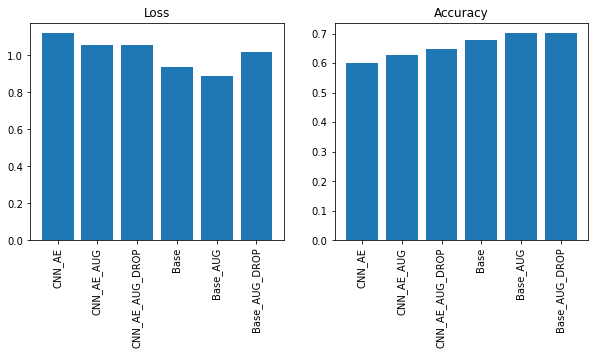

In [472]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(x=np.arange(0,len(model_labels),1), height=test_losses)
plt.xticks(ticks = np.arange(0,len(model_labels),1), labels = model_labels)
plt.xticks(rotation=90)
plt.title("Loss")

plt.subplot(1,2,2)
plt.bar(x=np.arange(0,len(model_labels),1), height=test_accs)
plt.xticks(ticks = np.arange(0,len(model_labels),1), labels = model_labels)
plt.xticks(rotation=90)
plt.title("Accuracy")

plt.show()

In [473]:
test_losses


[1.119483232498169,
 1.058289647102356,
 1.0575289726257324,
 0.9357954263687134,
 0.8881043791770935,
 1.0177443027496338]